In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix as cm

In [52]:
netflix = pd.read_csv('netflix_titles.csv')

netflix

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...,...,...,...,...,...,...,...,...
7782,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


In [53]:
#1
#Understanding what content is available in different countries

In [58]:
# Create a new column 'multiple_countries' to identify rows with more than one country
netflix['multiple_countries'] = netflix['country'].apply(lambda x: len(str(x).split(', ')) > 1)

# Extract rows where multiple countries are present
multiple_countries_data = netflix[netflix['multiple_countries']].copy()

# Display the relevant rows with multiple countries
multiple_countries_data[['show_id', 'title', 'country']].head()


,show_id,title,country
11,s12,1983,"Poland, United States"
17,s18,22-Jul,"Norway, Iceland, United States"
48,s49,10 Days in Sun City,"South Africa, Nigeria"
50,s51,"10,000 B.C.","United States, South Africa"
54,s55,100 Meters,"Portugal, Spain"


In [59]:
def expand_countries(row):
    countries = str(row['country']).split(', ')
    return [row.to_dict() for country in countries]

# Apply the function to rows with multiple countries and concatenate the results
expanded_rows = pd.concat([pd.DataFrame(expand_countries(row)) for _, row in multiple_countries_data.iterrows()], ignore_index=True)

# Update the 'country' column in the expanded rows to have one country per row
for index, row in expanded_rows.iterrows():
    expanded_rows.at[index, 'country'] = str(row['country']).split(', ')[index % len(str(row['country']).split(', '))]

# Remove the original rows with multiple countries from the main dataframe
netflix = netflix[~netflix['multiple_countries']].drop('multiple_countries', axis=1)

# Append the expanded rows to the main dataframe
netflix_expanded = pd.concat([netflix, expanded_rows.drop('multiple_countries', axis=1)], ignore_index=True)

# Display the modified dataframe to verify the changes
netflix_expanded.loc[netflix_expanded['show_id'].isin(['s12', 's18', 's49', 's51', 's55'])].sort_values('show_id')[['show_id', 'title', 'country']].head(10)


,show_id,title,country
6637,s12,1983,Poland
6638,s12,1983,United States
6639,s18,22-Jul,United States
6640,s18,22-Jul,Norway
6641,s18,22-Jul,Iceland
6642,s49,10 Days in Sun City,Nigeria
6643,s49,10 Days in Sun City,South Africa
6644,s51,"10,000 B.C.",South Africa
6645,s51,"10,000 B.C.",United States
6646,s55,100 Meters,Spain


In [61]:
netflix_expanded

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...,...,...,...,...,...,...,...,...
9565,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...",Denmark,"October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
9566,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...",Netherlands,"October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
9567,s7787,Movie,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS,Sam Dunn,NaN,United States,"March 1, 2020",2019,TV-MA,90 min,"Documentaries, Music & Musicals",This documentary delves into the mystique behi...
9568,s7787,Movie,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS,Sam Dunn,NaN,United Kingdom,"March 1, 2020",2019,TV-MA,90 min,"Documentaries, Music & Musicals",This documentary delves into the mystique behi...


In [62]:
country_preference = netflix_expanded.pivot_table(index='country', columns='type', aggfunc='size', fill_value=0)

# Adding a new column 'Total' to sum Movies and TV Shows for sorting purposes
country_preference['Total'] = country_preference.sum(axis=1)

# Sorting the countries by the total number of Movies and TV Shows in descending order
country_preference_sorted = country_preference.sort_values('Total', ascending=False)

# Displaying the top 20 entries after sorting
country_preference_sorted.head(10)


type,Movie,TV Show,Total
country,,,
United States,2430,866,3296
India,915,75,990
United Kingdom,466,256,722
Canada,286,126,412
France,265,84,349
Japan,103,184,287
Spain,158,57,215
South Korea,55,157,212
Germany,157,42,199


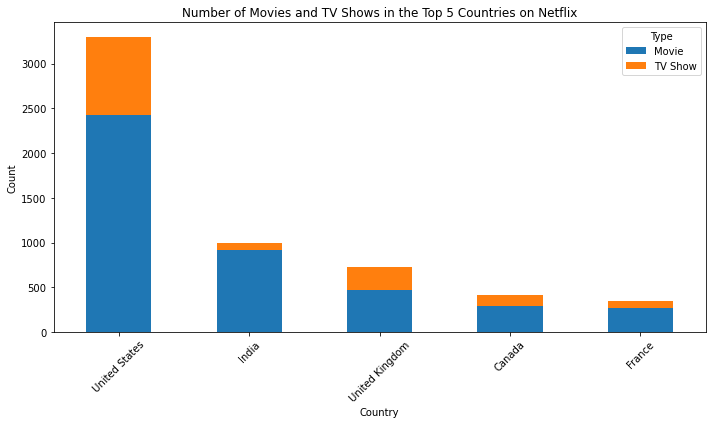

In [63]:
top_5_countries = country_preference_sorted.head(5)

# Creating the bar chart
top_5_countries.drop('Total', axis=1).plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Movies and TV Shows in the Top 5 Countries on Netflix')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()

# Displaying the plot
plt.show()


In [26]:
#2
#Netflix has been increasingly focusing on TV rather than movies in recent years. 
#Is this true? Answer using a visual.


In [64]:
netflix2 = pd.read_csv('netflix_titles.csv')

netflix2

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...,...,...,...,...,...,...,...,...
7782,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


In [67]:
netflix2['date_added'] = pd.to_datetime(netflix2['date_added'])

netflix2['year_added'] = netflix2['date_added'].dt.year

netflix2.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0


In [68]:
new_adds = netflix2.pivot_table(index='year_added', columns='type', aggfunc='size', fill_value=0)

new_adds

type,Movie,TV Show
year_added,,
2008.0,1,1
2009.0,2,0
2010.0,1,0
2011.0,13,0
2012.0,3,0
2013.0,6,5
2014.0,19,6
2015.0,58,30
2016.0,258,185


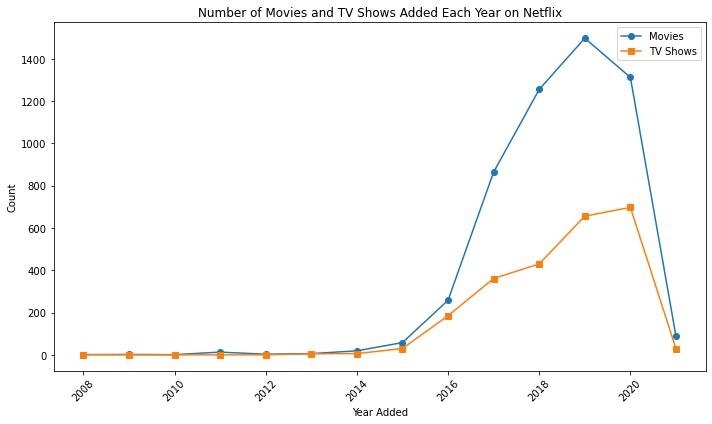

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(new_adds.index, new_adds['Movie'], marker='o', label='Movies')
plt.plot(new_adds.index, new_adds['TV Show'], marker='s', label='TV Shows')

plt.title('Number of Movies and TV Shows Added Each Year on Netflix')
plt.xlabel('Year Added')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

In [70]:
#3
#Predict the Type (movie or TV show) using a classification algorithm we have learnt. 
#You can use as many X variables as you want. Show ID will not help, encoding the Cast column will be useless. 
#Aside from these, encode the other variables. 
#Break the date down into weekdays and use that variable instead of the actual Date variable for predictions.


In [76]:
netflix_expanded.dropna(inplace=True)
netflix_expanded['date_added'] = pd.to_datetime(netflix_expanded['date_added'])
netflix_expanded['weekday_added'] = netflix_expanded['date_added'].dt.weekday

netflix_expanded.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,weekday_added
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,4
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",3
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",3
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2
5,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,2017-07-01,2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...,5


In [77]:
variable_counts = netflix_expanded['rating'].value_counts()

print(variable_counts)

TV-MA       1995
TV-14       1283
R           1009
PG-13        590
TV-PG        483
PG           360
TV-Y7         91
TV-G          89
TV-Y          89
NR            79
G             57
UR             7
TV-Y7-FV       4
NC-17          4
Name: rating, dtype: int64


In [80]:
# Encode categorical variables
label_encoder = LabelEncoder()
netflix_expanded['country_encoded'] = label_encoder.fit_transform(netflix_expanded['country'])
netflix_expanded['type_encoded'] = label_encoder.fit_transform(netflix_expanded['type'])

rating_mapping = {
    'TV-MA': 13,
    'R': 12,
    'NC-17':11,
    'TV-14':10,
    'PG-13': 9,
    'PG':8,
    'TV-PG':7,
    'TV-G': 6,
    'TV-Y7-FV':5,
    'TV-Y7':4,
    'TV-Y':3,
    'G':2,
    'NR':1,
    'UR':0
}

netflix_expanded['rating_encoded'] = netflix_expanded['rating'].apply(lambda x: rating_mapping.get(x, 0))

netflix_expanded.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,weekday_added,country_encoded,type_encoded,rating_encoded
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,4,57,0,13
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",3,81,0,12
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",3,98,0,9
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2,98,0,9
5,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,2017-07-01,2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...,5,95,1,13


In [81]:
# Feature selection
X = netflix_expanded[['country_encoded', 'weekday_added', 'release_year', 'rating_encoded']]
y = netflix_expanded['type_encoded']


In [82]:
# Model selection and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [83]:
# Prediction and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9690553745928339


In [84]:
print('Confusion Matrix:\n' , confusion_matrix(y_test,y_pred))

Confusion Matrix:
 [[1190    0]
 [  38    0]]


In [85]:
# Break the data up into training and test sets. 
#Apply Logistic, KNN and Decision trees. Report their accuracy levels. 
#Which one is outperforming the others?

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [87]:
logistic_model = LogisticRegression()
knn_model = KNeighborsClassifier()
tree_model = DecisionTreeClassifier()

In [88]:
# Train and evaluate Logistic Regression
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_pred)

In [89]:
# Train and evaluate KNN
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

In [90]:
# Train and evaluate Decision Tree
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, tree_pred)

In [91]:
for model in [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier()]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
   
    print(model,'Confusion Matrix:\n' , confusion_matrix(y_test,y_pred))

LogisticRegression() Confusion Matrix:
 [[1487    0]
 [  48    0]]
KNeighborsClassifier() Confusion Matrix:
 [[1487    0]
 [  48    0]]
DecisionTreeClassifier() Confusion Matrix:
 [[1469   18]
 [  44    4]]


In [92]:
# Report the accuracies
print(f"Logistic Regression Accuracy: {logistic_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")
print(f"Decision Tree Accuracy: {tree_accuracy}")

Logistic Regression Accuracy: 0.968729641693811
KNN Accuracy: 0.968729641693811
Decision Tree Accuracy: 0.9583061889250815


In [93]:
# Determine which model is outperforming
best_model = max(logistic_accuracy, knn_accuracy, tree_accuracy)
if best_model == logistic_accuracy:
    print("Best performing model: Logistic Regression")
elif best_model == knn_accuracy:
    print("Best performing model: KNN")
else:
    print("Best performing model: Decision Tree")

Best performing model: Logistic Regression


In [94]:
for model in [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier()]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    matrix = cm(y_test, y_pred)
    print(f"{model} Confusion Matrix:\n{matrix}")
    
    TP = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TN = matrix[1][1]
    
    precision_movie = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall_movie = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score_movie = 2 * (precision_movie * recall_movie) / (precision_movie + recall_movie) if (precision_movie + recall_movie) != 0 else 0
    
    precision_show = TN / (TN + FN) if (TN + FN) != 0 else 0
    recall_show = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1_score_show = 2* (precision_show * recall_show) / (precision_show + recall_show) if (precision_show + recall_show) != 0 else 0
    
    print(f"Precision Movie: {precision_movie}")
    print(f"Recall Movie: {recall_movie}")
    print(f"F1-score Movie: {f1_score_movie}\n")

    print(f"Precision TV Show: {precision_show}")
    print(f"Recall TV Show: {recall_show}")
    print(f"F1-score TV Show: {f1_score_show}\n")


LogisticRegression() Confusion Matrix:
[[1487    0]
 [  48    0]]
Precision Movie: 1.0
Recall Movie: 0.968729641693811
F1-score Movie: 0.9841164791528788

Precision TV Show: 0.0
Recall TV Show: 0
F1-score TV Show: 0

KNeighborsClassifier() Confusion Matrix:
[[1487    0]
 [  48    0]]
Precision Movie: 1.0
Recall Movie: 0.968729641693811
F1-score Movie: 0.9841164791528788

Precision TV Show: 0.0
Recall TV Show: 0
F1-score TV Show: 0

DecisionTreeClassifier() Confusion Matrix:
[[1467   20]
 [  44    4]]
Precision Movie: 0.9865501008742434
Recall Movie: 0.970880211780278
F1-score Movie: 0.9786524349566378

Precision TV Show: 0.08333333333333333
Recall TV Show: 0.16666666666666666
F1-score TV Show: 0.1111111111111111



In [95]:
#5
#How can their recommendation system be improved based on what you see? 
#Is there a certain weekday they should launch the show on? 
#Is there a certain duration that people prefer? A certain rating?

In [96]:
print("Intercept:",logistic_model.intercept_)
print("Coefficients:", logistic_model.coef_)

Intercept: [-0.0009244]
Coefficients: [[ 0.00584483  0.0943696  -0.00180999 -0.07005357]]


In [97]:
feature_names = ['country_encoded', 'weekday_added', 'release_year', 'rating_encoded']

intercept = logistic_model.intercept_[0]
coefficients = logistic_model.coef_[0]

coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coefficients_df = pd.concat([pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept]}), coefficients_df], ignore_index=True)

print(coefficients_df)


           Feature  Coefficient
0        Intercept    -0.000924
1  country_encoded     0.005845
2    weekday_added     0.094370
3     release_year    -0.001810
4   rating_encoded    -0.070054


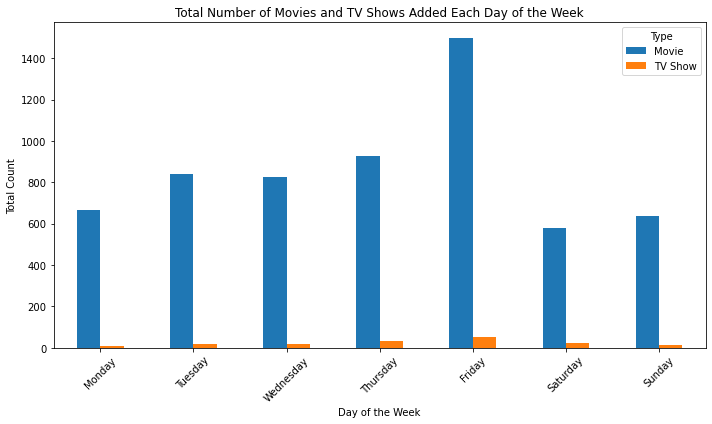

In [98]:
# Group by 'weekday_added' and 'type', then count the number of occurrences
weekday_counts = netflix_expanded.groupby(['weekday_added', 'type']).size().unstack(fill_value=0)

# Plotting the histogram
weekday_counts.plot(kind='bar', figsize=(10, 6))

plt.title('Total Number of Movies and TV Shows Added Each Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.legend(title='Type')
plt.tight_layout()

plt.show()
